# Stock Price Predictor - Model Training and Testing

## Notebook Overview
- [1. ARIMA Model](#ARIMA-Model)
    - [1.1 Loading data](#load-data-1)
    - [1.2 Determine Parameters](#define-parameters-1)
    - [1.3 Train ARIMA Model](#train-model-1)
    - [1.4 Evaluate Model Perfomance](#evaluate-performance-1)
    - [1.5 Hyperparameter Tuning - ARIMA](#hyperparameter-tuning-1)
    - [1.6 Generate Predictions - ARIMA](#generate-predictions-1)
- [2. DeepAR Model](#DeepAR-Model)
    - [2.1 Loading Data](#load-data-2)
    - [2.2 Setting Hyperparameters](#define-hyperparameters-2)
    - [2.3 Train DeepAR Estimator](#train-model-2)
    - [2.4 Deploy and Evaluate Model Perfomance](#evaluate-performance-2)
    - [2.5 Hyperparameter Tuning - DeepAR](#hyperparameter-tuning-2)
    - [2.6 Generate Predictions - DeepAR](#generate-predictions-2)
- [3. Visualise and Compare Predictions](#visualise-results)
- [4. Experimentation](#experimentation)
- [5. Conclusion](#conclusion)

## Plan of Action
ARIMA and DeepAR models will be trained and their predictions will be saved, visualised and compared in this notebook.

<a id="load-data-1"></a>
## 1.1 Load Data

In [1]:
import os
import pytz
import json
import math
import time
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_absolute_error, mean_squared_error

pd.set_option('display.max_rows', None)
timezone_str = 'Asia/Kolkata'
localtz = pytz.timezone(timezone_str)

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot

import warnings
warnings.filterwarnings('ignore')

csv_data_dir = 'data/csv_aapl_data'
json_data_dir = 'data/json_aapl_data'

In [42]:
# Load stocks data
stock_names = {'^GSPC': 'S&P 500',
               '^BSESN': 'S&P BSE SENSEX',
               'AAPL': 'Apple Inc.'}

data_dir = 'data'
data = {}

for stock in stock_names.keys():
    data[stock] = pd.read_csv(os.path.join(data_dir, stock + '.csv'),
                              parse_dates=True, index_col=['Date'])
    data[stock] = data[stock].dropna()
    
df = data['AAPL'].index
idx = pd.date_range(min(df.date), max(df.date))
aapl_updated = data['AAPL'].copy().reindex(idx)
aapl_data = aapl_updated.copy().interpolate()

<a id="ARIMA-Model"></a>
# 1. ARIMA Model
## Import Data

In [3]:
# Import one time series data
csv_data_dir = 'data/csv_aapl_data'

arima_train = pd.read_csv(os.path.join(csv_data_dir, 'train.csv'), parse_dates=[0], index_col=0, squeeze=True)
arima_test = pd.read_csv(os.path.join(csv_data_dir, 'test.csv'), parse_dates=[0], index_col=0, squeeze=True)
arima_test.head()

2000-01-01    0.816721
2000-01-02    0.840189
2000-01-03    0.863657
2000-01-04    0.790842
2000-01-05    0.802415
Name: Adj Close, dtype: float64

## 1.1 Determine Parameters
ARIMA model requires three parameters to be defined.
1. Number of `auto-regressive terms` (p)
2. Number of `differences` (d)
3. Number of `moving average terms` (q)

Values `p` and `q` can be determined using `ACF` and `PACF` plots and can further be improved by minimizing `AIC` and `BIC` values (more on the metrics). While `d` can be determined using the stationarity of the time series. The stationarity of a time series will be measured using the `Augmented Dickey-Fuller Test` and plot of the modified series.

> **Source**: Jain, A. (2016) Time Series Forecasting In Python | R. doi: 10.1201/9781420000269.ch12. *Available at: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

In [4]:
def stationarity_stats(time_series: pd.Series, window_size = 10):
    """The function plots and prints the necessary statistics needed to determine if a
    series can be assumed to be stationary.
    
    Args:
        time_series (pd.Series): series that is to be tested for stationarity.
    """
    
    #Determing rolling statistics
    ts_moving_avg = time_series.rolling(window_size).mean()
    ts_moving_std = time_series.rolling(window_size).std()

    #Plot statistics data
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.style.use('seaborn')
    
    time_series.plot(color='blue',
                     ax=ax,
                     label='Time Series')
    ts_moving_avg.plot(color='yellow',
                       ax=ax,
                       label='Moving Average')
    ts_moving_std.plot(color='green',
                       ax=ax,
                       label='Standard Deviation')
    plt.legend(loc='best')
    ax.set_title('Time Series with Moving Avearage & Rolling Standard Deviation',
                 fontdict={'size': 20, 'weight': 'bold'})
    ax.set_xlabel('Timestamp', fontdict={"size": 14})
    ax.set_ylabel('Price ($)', fontdict={"size": 14})
    
    leg = ax.legend(fontsize=16, frameon=True)
    leg.get_frame().set_color('#F2F2F2')
    leg.get_frame().set_edgecolor('black')
    leg.set_title("Legend", prop={"size": 20, "weight": 'bold'})
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    
    #Calculate resutls of the Dickey-Fuller test
    test_results = adfuller(time_series, autolag='AIC')
    data = ['Test Statistic',
            'p-value',
            'Number of Lags Used',
            'Number of Observations Used']
    for name, value in zip(data, test_results[:4]):
        print(f'{name}: {value: .4f}')

    for key, value in test_results[4].items():
        print(f'{key} Critical Value: {value: .3f}')

In [8]:
def plot_acf_pacf(data_acf, data_pacf, length):
    # plot data
    fig, axes = plt.subplots(nrows=1,
                             ncols=2,
                             figsize=(20,8))

    plot_titles = ['Autocorreleration Function',
                   'Partial Autocorreleration Function']
    # ax_pacf.plot(data_pacf)

    for ax, title, plot_data in zip(axes, plot_titles, (data_acf, data_pacf)):
        ax.bar(x=range(len(plot_data)), height=plot_data, width=0.1)
        ax.axhline(y=0,linestyle='--',color='gray')
        ax.axhline(y=-1.96/np.sqrt(length),linestyle='-',color='gray')
        ax.axhline(y=1.96/np.sqrt(length),linestyle='-',color='gray')
        ax.set_title(title, fontdict={'size': 20, 'weight': 'bold'})
        ax.set_xlabel('Lag Value')

    fig.suptitle("Autocorrelation Plots of Log of Time Series and First Degree of Differencing",
                  fontsize=24, fontweight= 'bold');

Test Statistic: -12.3349
p-value:  0.0000
Number of Lags Used:  35.0000
Number of Observations Used:  6962.0000
1% Critical Value: -3.431
5% Critical Value: -2.862
10% Critical Value: -2.567


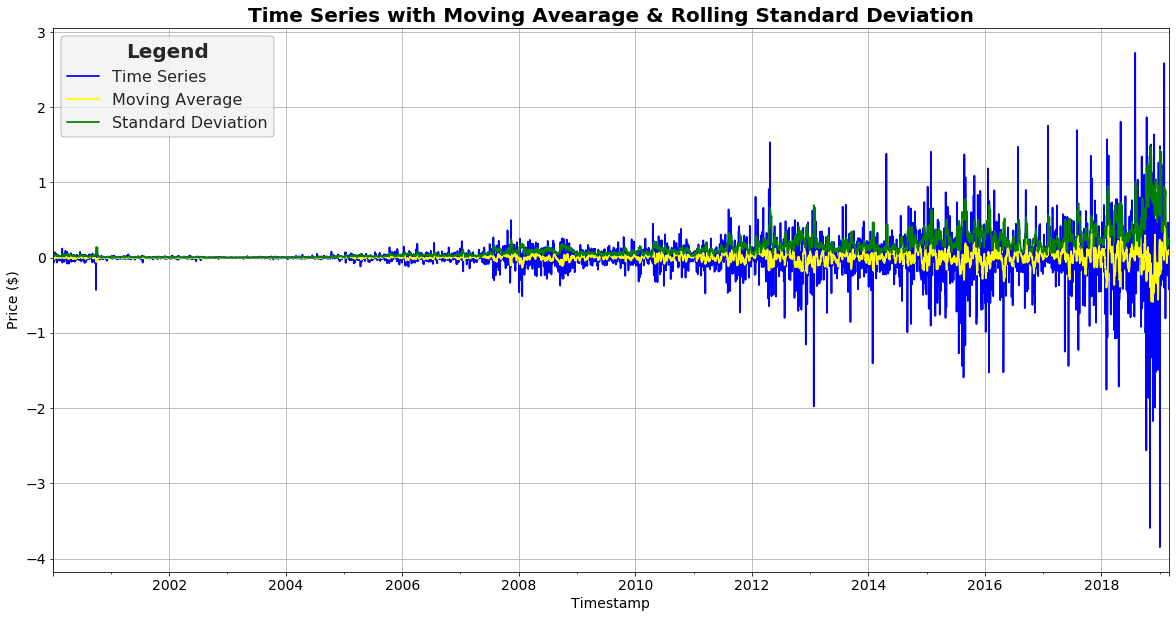

In [6]:
ts_diff = arima_train.diff()
stationarity_stats(ts_diff.dropna())

It can be seen that the `Test Statistic` value of **-12.33** for the test data is less than `1% Critical Value` of **-3.43**. Hence, it can be assumed with 99% confidence that the series is stationary.

However, after viewing the graph, it is clear that the series shows strong signs of being non-stationary towards the end. Log of series can be used to improve the stationarity of the series - explored in [Hyperparameter Tuning](#hyperparameter-tuning-1) Section

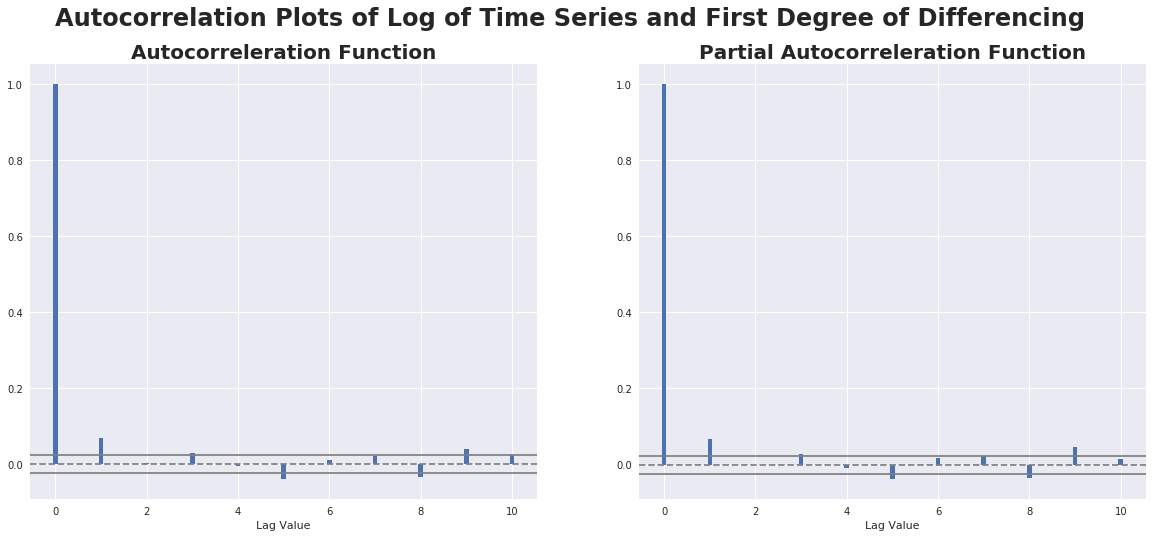

In [9]:
# Calculate values for ACF and PACF
data_acf = acf(ts_diff.dropna(), nlags=10)
data_pacf = pacf(ts_diff.dropna(), nlags=10, method='ols-unbiased')

plot_acf_pacf(data_acf, data_pacf, len(ts_diff))

From the above graphs, values of `p` and `q` should be `1` as in the above graphs correlation with one previous value is significant. The sold black lines are confidence intervals. An optimal value of `p` can be tentatively selected by looking at the pacf plot and for `q` can be decided by the acf plot. These could later be change to improve model performance (reduce `AIC` and `BIC`). Hence, the parameter values for the ARIMA model should be as follows:
- **Number of `differences` (d) = 1**
- **Number of `auto-regressive terms` (p) = 1**
- **Number of `moving average terms` (q) = 1**

<a id="train-model-1"></a>
# 1.2 Train ARIMA Model
We can see how the model performs with the first basic parameters and stationary series we have obtained from the analysis above.

An ARIMA model will be trained using parameters `(p, d, q) = (1, 1, 1)`. 

In [10]:
t0 = time.time()
# Instantiate and train ARIMA model
arima_model = ARIMA(arima_train, order=(1, 1, 1))

results_arima = arima_model.fit()
print(results_arima.summary())

print(f'Time taken: {round(time.time()-t0, 0)}')

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 6999
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 523.552
Date:                Sun, 01 Nov 2020   AIC                          -1041.103
Time:                        02:30:54   BIC                          -1020.543
Sample:                    01-01-2000   HQIC                         -1034.019
                         - 02-28-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0720      0.072      0.994      0.320      -0.070       0.214
ma.L1         -0.0032      0.073     -0.043      0.965      -0.146       0.140
sigma2         0.0504      0.000    278.808      0.0

In [11]:
pred_start = max(arima_train.index.date) + pd.DateOffset(days=1)
pred_end = max(arima_test.index.date)

arima_preds = results_arima.predict(start=pred_start, end=pred_end)
idx = pd.date_range(pred_start, pred_end)
arima_preds = arima_preds.reindex(idx)
arima_preds.head()

2019-03-01    42.507118
2019-03-02    42.505025
2019-03-03    42.504874
2019-03-04    42.504863
2019-03-05    42.504862
Freq: D, dtype: float64

<a id="evaluate-performance-1"></a>
## 1.3 Evaluate Model Perfomance
`Mean Absolute Percentage Error (MAPE)` will be used measure the performance of the model.

In [12]:
# Creating a function to evaluate performance of the model.
def evaluate_model(y_true, y_preds, train_ts=None):
    """The function plots the results obtained on a graph, calculates metric values and returns it.
    
    Args:
        train_ts (pd.Series): the series the model was trained on.
        y_true (pd.Series): true values of the time series.
        y_preds (pd.Series): predicted values of the time series.
        
    Returns:
        dict: with the values of all the metrics printed.
    
    """
    if train_ts is not None:
        pass
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    y_true.plot(ax=ax,
                color='green',
                label='True Series')
    y_preds.plot(ax=ax,
                 color='blue',
                 label='Predicted Series')
    
    plt.legend(loc='best')
    ax.set_title('Time Series Predictions',
                 fontdict={'size': 20, 'weight': 'bold'})
    ax.set_xlabel('Timestamp', fontdict={"size": 14})
    ax.set_ylabel('Price ($)', fontdict={"size": 14})
    
    leg = ax.legend(fontsize=16, frameon=True)
    leg.get_frame().set_color('#F2F2F2')
    leg.get_frame().set_edgecolor('black')
    leg.set_title("Legend", prop={"size": 20, "weight": 'bold'})
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    # report performance
    performance_dict = {
        "mae": mean_absolute_error(y_true, y_preds),
        "mse": mean_squared_error(y_true, y_preds),
        "rmse": math.sqrt(mean_squared_error(y_true, y_preds)),
        "mape": np.mean(np.abs((y_preds - y_true)/y_true))
    }
    
    print("######### Metric Scores ##########\n"
          "Mean Absolute Error:            {mae: .2f}\n"
          "Mean Squared Error:             {mse: .2f}\n"
          "Root Mean Squared Error:        {rmse: .2f}\n"
          "Mean Absolute Percentage Error: {mape: 0.2%}\n".format(**performance_dict))

    return performance_dict

######### Metric Scores ##########
Mean Absolute Error:             11.12
Mean Squared Error:              184.79
Root Mean Squared Error:         13.59
Mean Absolute Percentage Error:  19.18%



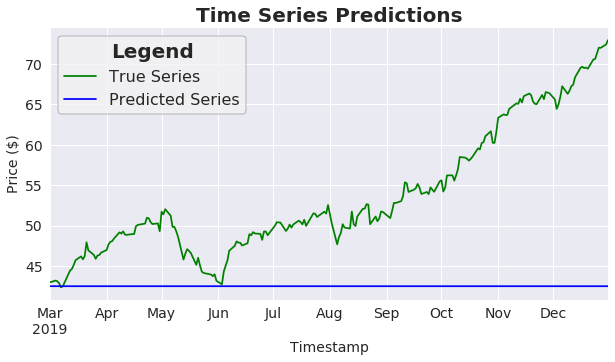

In [13]:
evaluate_model(arima_test[pred_start:pred_end], arima_preds, arima_train);

The results obtained have yielded a `MAPE of 19.2%`, which is an accuracy of `80.8%`. Though the number is good, we can see in the graph that the model is not doing the best at following the tred. I will now manually experiment with different values of `(p, d, q)` to determine what is best for this series.

In [14]:
t0 = time.time()

# Instantiate and train ARIMA model
arima_model = ARIMA(arima_train, order=(1, 3, 2))

results_arima = arima_model.fit()
print(results_arima.summary())

print(f'Time taken: {round(time.time()-t0, 0)}')

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 6999
Model:                 ARIMA(1, 3, 2)   Log Likelihood                 499.245
Date:                Sun, 01 Nov 2020   AIC                           -990.489
Time:                        02:31:13   BIC                           -963.077
Sample:                    01-01-2000   HQIC                          -981.043
                         - 02-28-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0713      0.004     16.065      0.000       0.063       0.080
ma.L1         -1.9998      0.005   -396.851      0.000      -2.010      -1.990
ma.L2          0.9998      0.005    198.390      0.0

The `P>|z|` values for all the `coef` values is less than 0.05. Hence, it can be said that the values of the coefficient are significant. Let's predict and evaluate the results to be better understand what is going on.

In [15]:
arima_preds = results_arima.predict(start=pred_start, end=pred_end)
idx = pd.date_range(pred_start, pred_end)
arima_preds = arima_preds.reindex(idx)
arima_preds.head()

2019-03-01    42.525326
2019-03-02    42.543727
2019-03-03    42.564136
2019-03-04    42.584613
2019-03-05    42.605018
Freq: D, dtype: float64

######### Metric Scores ##########
Mean Absolute Error:             9.25
Mean Squared Error:              138.07
Root Mean Squared Error:         11.75
Mean Absolute Percentage Error:  15.79%



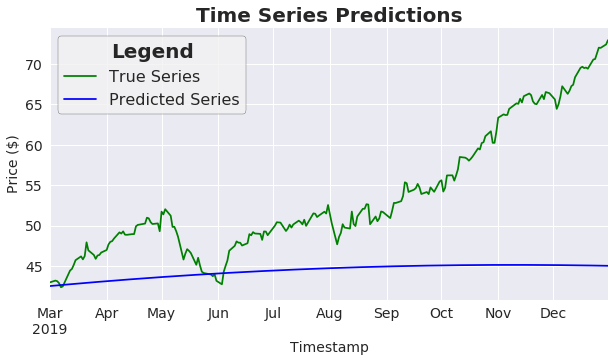

In [16]:
evaluate_model(arima_test[pred_start:pred_end], arima_preds, arima_train);

There was a `3%` improvement with a some manual hyperparameter tuning as the MAPE value is now at `15.8%`. From the graph we can also infer how there is a lot more scope for improvement. Let's look at the residuals to check if the model is plotting what we expect it to.

Some of the following lines of code were taken from the source below.
> **Source**: Selva, P. (2019) ‘ARIMA Model - Complete Guide to Time Series Forecasting in Python | ML+’, Time Series, pp. 1–43. Available at: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/ (Accessed: 30 October 2020).

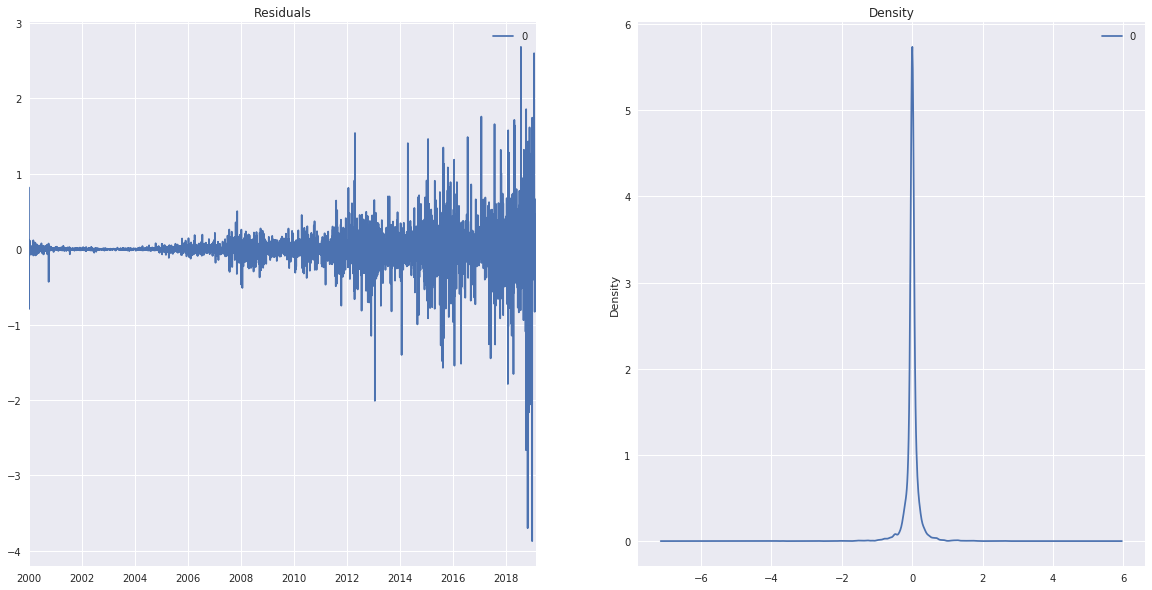

In [17]:
residuals = pd.DataFrame(results_arima.resid)
fig, ax = plt.subplots(1,
                       2,
                       figsize=(20,10))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1]);

<a id="hyperparameter-tuning-1"></a>
## 1.5 Hyperparameter Tuning - ARIMA
In this section we will try to improve the model by doing two things:
1. Improve the stationarity of the time series.
2. Trying different values of `(p, d, q)` parameters.

I believe the time series can further be made stationary by using the `log` of it. Let's see how that goes.

In [18]:
def prepare_data(time_series):
    ts_log = np.log(time_series)
    return ts_log

def reverse_data(ts_log):
    ts = np.exp(ts_log)
    return ts

Test Statistic: -29.4976
p-value:  0.0000
Number of Lags Used:  6.0000
Number of Observations Used:  6991.0000
1% Critical Value: -3.431
5% Critical Value: -2.862
10% Critical Value: -2.567


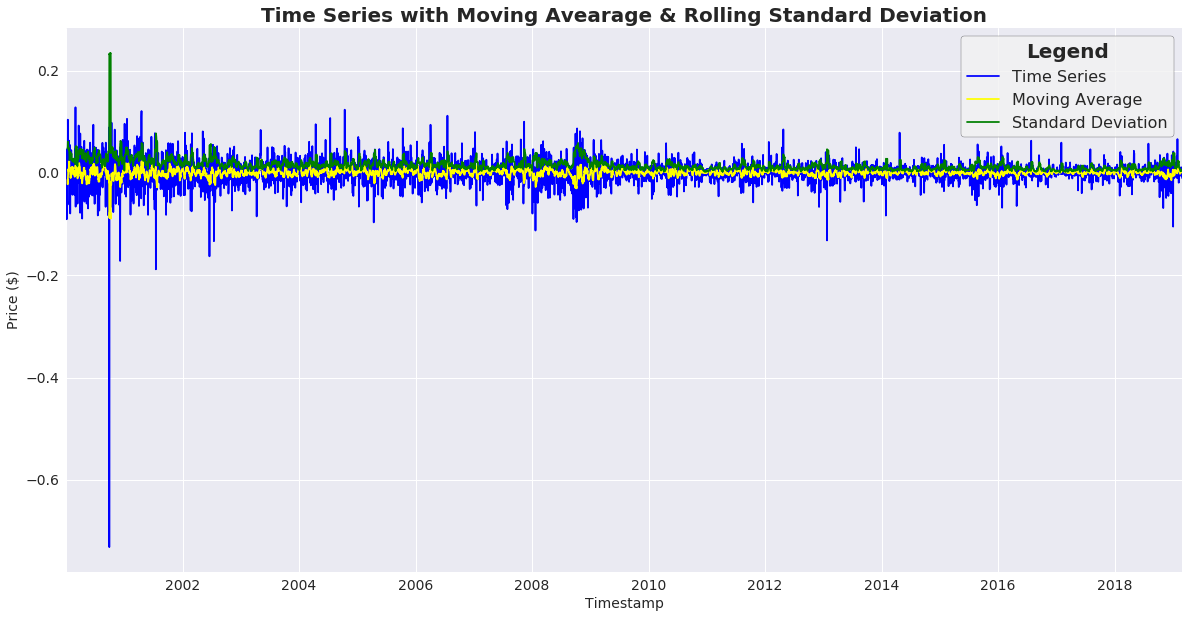

In [19]:
ts_log = np.log(arima_train)
ts_log_diff = ts_log.diff()
stationarity_stats(ts_log_diff.dropna())

The value of `Test Statistic` has drastically reduced to **-29.50**. Additionally, the graph shows strong signs of stationarity. Hence, `ts_log` should be used to train and test the ARIMA model and the value of `d` should be `0`. Notice the number of lags used is `6`.

*Note: `Decomposing` could further improve the stationarity of the series. This is beyond the scope of this project and can be explored later.*

Determining a valid value of `p` and `q` using `ACF` and `PACF` plots.

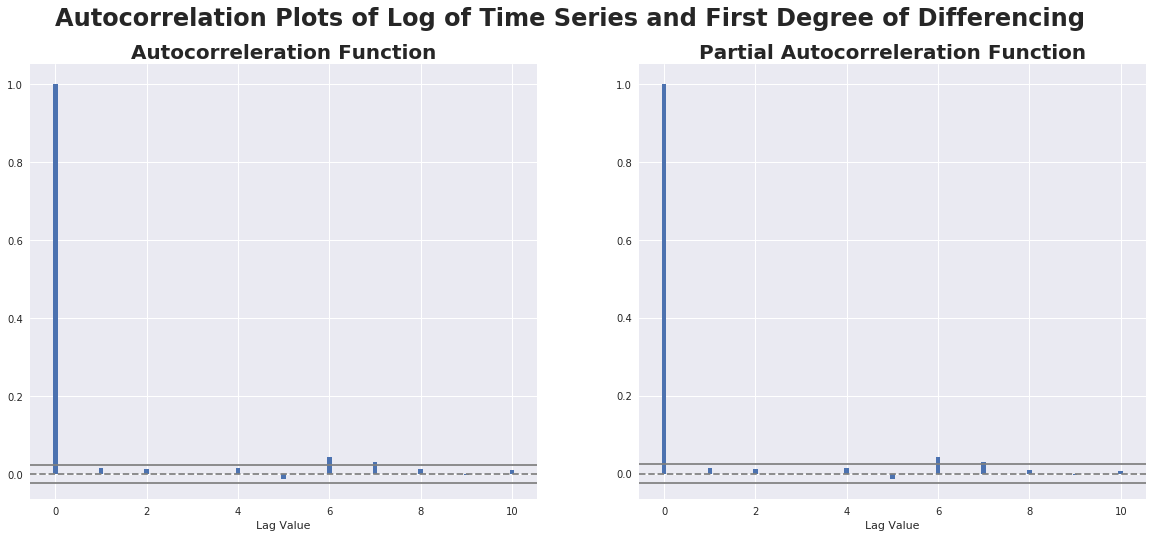

In [21]:
# Calculate values for ACF and PACF
data_acf = acf(ts_log_diff.dropna(), nlags=10)
data_pacf = pacf(ts_log_diff.dropna(), nlags=10, method='ols')

plot_acf_pacf(data_acf, data_pacf, len(ts_log_diff))

From the above graphs, values of `p` and `q` should be `0`. These could later be change to improve model performance (reduce `AIC` and `BIC`). Hence, the parameter values for the ARIMA model should be as follows:
- **Number of `differences` (d) = 1**
- **Number of `auto-regressive terms` (p) = 0**
- **Number of `moving average terms` (q) = 0**

An ARIMA model will be trained using parameters `(p, d, q) = (0, 1, 0)`. 

In [22]:
t0 = time.time()
# Convert train time series into log series
train_ts = prepare_data(arima_train)

# Instantiate and train ARIMA model
arima_model = ARIMA(train_ts, order=(0, 1, 0))

results_arima = arima_model.fit()
print(results_arima.summary())

print(f'Time taken: {round(time.time()-t0, 0)}')

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 6999
Model:                 ARIMA(0, 1, 0)   Log Likelihood               17167.503
Date:                Sun, 01 Nov 2020   AIC                         -34333.006
Time:                        02:32:04   BIC                         -34326.152
Sample:                    01-01-2000   HQIC                        -34330.644
                         - 02-28-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0004    6.9e-07    627.505      0.000       0.000       0.000
Ljung-Box (Q):                       86.38   Jarque-Bera (JB):          14682832.91
Prob(Q):                              0.00   Pr

In [23]:
arima_preds = reverse_data(results_arima.predict(start=pred_start, end=pred_end))
idx = pd.date_range(pred_start, pred_end)
arima_preds = arima_preds.reindex(idx)
arima_preds.head()

2019-03-01    42.536182
2019-03-02    42.536182
2019-03-03    42.536182
2019-03-04    42.536182
2019-03-05    42.536182
Freq: D, dtype: float64

######### Metric Scores ##########
Mean Absolute Error:             11.09
Mean Squared Error:              184.09
Root Mean Squared Error:         13.57
Mean Absolute Percentage Error:  19.12%



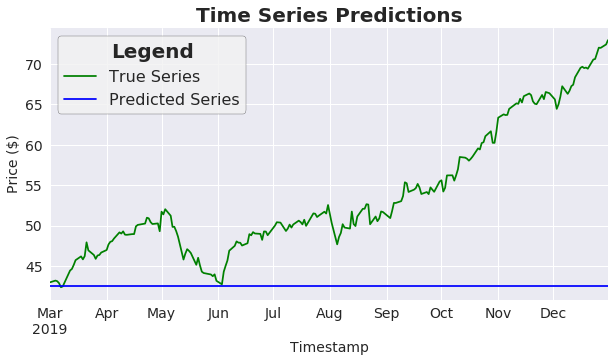

In [24]:
evaluate_model(arima_test[pred_start:pred_end].interpolate(), arima_preds.interpolate(), arima_train);

As expected it came out to be a straight line. This is because there is not `AR` or `MA` being used. Hence, the prediction will be a straight line. With this we have got a MAPE value of `19.1%`, which is higher than the one we recieved. Some manual tuning shall yield better results.

In [25]:
t0 = time.time()

# Instantiate and train ARIMA model
arima_model = ARIMA(train_ts, order=(0, 2, 3))

results_arima = arima_model.fit()
print(results_arima.summary())

print(f'Time taken: {round(time.time()-t0, 0)}')

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 6999
Model:                 ARIMA(0, 2, 3)   Log Likelihood               17164.125
Date:                Sun, 01 Nov 2020   AIC                         -34320.249
Time:                        02:32:37   BIC                         -34292.836
Sample:                    01-01-2000   HQIC                        -34310.803
                         - 02-28-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9852      0.009   -113.737      0.000      -1.002      -0.968
ma.L2         -0.0031      0.013     -0.241      0.809      -0.028       0.022
ma.L3         -0.0104      0.011     -0.957      0.3

######### Metric Scores ##########
Mean Absolute Error:             8.93
Mean Squared Error:              123.95
Root Mean Squared Error:         11.13
Mean Absolute Percentage Error:  15.33%



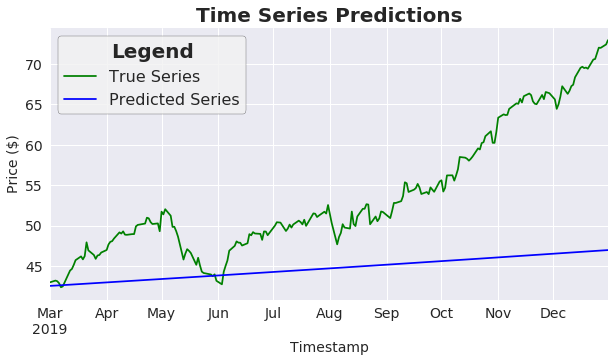

In [26]:
# Get predictions
arima_preds = reverse_data(results_arima.predict(start=pred_start, end=pred_end))
idx = pd.date_range(pred_start, pred_end)
arima_preds = arima_preds.reindex(idx)

# Evaluate Predictions
evaluate_model(arima_test[pred_start:pred_end].interpolate(), arima_preds.interpolate(), arima_train);

The best MAPE value till now has been acheived: `15.3%`. We could use grid search to further reduce MAPE value. A place to continue this hyperparameter tuning would be by looking the `P>|z|` values. There are two `coef` that are not significant and hence, the value of `q` can be reduced to `1`.

> *Note: As there was limited time to finish this project, I decided to move to work with DeepAR model at this point in time.*

<a id="DeepAR-Model"></a>
# 2. DeepAR Model
<a id="load-data-2"></a>
## 2.1 Loading Data - Upload to S3
Data is to be uploaded to S3 to give the estimator access to it.

Steps include:
- Create sagemaker role and session to train a model in.
- Save train, test and model data to the default S3 bucket.

In [27]:
import boto3
import sagemaker

In [28]:
# Create role and session
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()

In [29]:
# Save data
dar_train_key = os.path.join(json_data_dir, 'train.json')
dar_test_key = os.path.join(json_data_dir, 'test.json')

s3_prefix = 'deepar-aapl-stock'
dar_train_prefix = f'{s3_prefix}/train'
dar_test_prefix = f'{s3_prefix}/test'

deepar_train_path = sagemaker_session.upload_data(dar_train_key, bucket=bucket, key_prefix=dar_train_prefix)
print(f'Training data successfully stored in: {deepar_train_path}')
deepar_test_path = sagemaker_session.upload_data(dar_test_key, bucket=bucket, key_prefix=dar_test_prefix)
print(f'Test data successfully stored in: {deepar_test_path}')

Training data successfully stored in: s3://sagemaker-ap-south-1-792863643153/deepar-aapl-stock/train/train.json
Test data successfully stored in: s3://sagemaker-ap-south-1-792863643153/deepar-aapl-stock/test/test.json


<a id="define-hyperparameters-2"></a>
## 2.2 Instantiating Estimator and Setting Hyperparameters
Creating a base estimator and specifying a container image that contains the DeepAR model. Getting container image with DeepAR model using `get_image_uri` method.

In [30]:
from sagemaker.amazon.amazon_estimator import get_image_uri

image_name = get_image_uri(boto3.Session().region_name,
                           'forecasting-deepar')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [31]:
from sagemaker.estimator import Estimator

# Specifying location to save model artifacts
output_path = f's3://{bucket}/{s3_prefix}/output'

# Instantiating a DeepAR model
model = Estimator(image_name=image_name,
                  sagemaker_session=sagemaker_session,
                  role=role,
                  train_instance_count=1,
                  train_instance_type='ml.p2.xlarge',
                  output_path=output_path)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


### Setting Hyperparameters
Following are the required hyperparameters:
1. `epochs`: the maximum number of time the neural network should pass through the data.
    > Can be adjusted by viewing the change in errors after every epoch.
2. `time_freq`: the granularity of the time series provided.
    > It is **`D`** (Daily) for the data we have.
3. `prediction_length`: number of `time_freq` steps the model is trained to make predictions for.
    > It is 10 months as decided upon earlier, which is about **`300` days**.
4. `context_length`: number of `time_freq` steps that will be provided to the model before making a prediction.
    > As it is reccommended to start with context_length = prediction_length **`300` days** will be used. DeepAR model will "look further back in the time series" if needed for lag, hence it is not necessary to set this value to be a high value.
    
*Note: `context_length` can later be tuned to see if there are any improvements in the model.*

Some optional hyperparameters that I will modify include:
- `early_stopping_patience`: 7 (Default: None)
- `learning_rate`: 0.001 (Default: 0.001)
- `mini_batch_size`: 256 (Default: 128)
- `num_cells`: 70 (Default: 40)
- `num_eval_samples`: 300 (Default: 100)
- `num_layers`: 2 (Default: 2)

In [32]:
%time
hyperparameters = {
    "context_length": "300",
    "prediction_length": "300",
    "time_freq": "D",
    "epochs": "70",
    "early_stopping_patience": "7",
    "learning_rate": "0.001",
    "mini_batch_size": "256",
    "num_cells": "50",
    "num_eval_samples": "300",
    "num_layers": "2"
}

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


In [33]:
model.set_hyperparameters(**hyperparameters)

<a id="train-model-2"></a>
## 2.3 Train DeepAR Estimator
DeepAR takes both train and test data.

In [34]:
%time

data_channels = {
    "train": deepar_train_path,
    "test": deepar_test_path
}

model.fit(inputs=data_channels)

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs
2020-11-01 02:32:59 Starting - Starting the training job...
2020-11-01 02:33:01 Starting - Launching requested ML instances......
2020-11-01 02:34:05 Starting - Preparing the instances for training......
2020-11-01 02:35:23 Downloading - Downloading input data......
2020-11-01 02:36:09 Training - Downloading the training image.Arguments: train
[11/01/2020 02:36:32 INFO 140687824308032] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': 

[11/01/2020 02:37:54 INFO 140687824308032] Epoch[2] Batch[5] avg_epoch_loss=0.442246
[11/01/2020 02:37:54 INFO 140687824308032] #quality_metric: host=algo-1, epoch=2, batch=5 train loss <loss>=0.442246427139
[11/01/2020 02:37:54 INFO 140687824308032] Epoch[2] Batch [5]#011Speed: 116.97 samples/sec#011loss=0.442246
[11/01/2020 02:38:03 INFO 140687824308032] processed a total of 2519 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 23235.16011238098, "sum": 23235.16011238098, "min": 23235.16011238098}}, "EndTime": 1604198283.20578, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1604198259.97054}

[11/01/2020 02:38:03 INFO 140687824308032] #throughput_metric: host=algo-1, train throughput=108.412715027 records/second
[11/01/2020 02:38:03 INFO 140687824308032] #progress_metric: host=algo-1, completed 4 % of epochs
[11/01/2020 02:38:03 INFO 140687824308032] #quality_metric: host=algo-1, epoch=2, train loss <loss>=0.3956346

[11/01/2020 02:39:55 INFO 140687824308032] Epoch[7] Batch[5] avg_epoch_loss=-0.102236
[11/01/2020 02:39:55 INFO 140687824308032] #quality_metric: host=algo-1, epoch=7, batch=5 train loss <loss>=-0.102236193294
[11/01/2020 02:39:55 INFO 140687824308032] Epoch[7] Batch [5]#011Speed: 116.86 samples/sec#011loss=-0.102236
[11/01/2020 02:40:06 INFO 140687824308032] Epoch[7] Batch[10] avg_epoch_loss=-0.002176
[11/01/2020 02:40:06 INFO 140687824308032] #quality_metric: host=algo-1, epoch=7, batch=10 train loss <loss>=0.117896153033
[11/01/2020 02:40:06 INFO 140687824308032] Epoch[7] Batch [10]#011Speed: 116.28 samples/sec#011loss=0.117896
[11/01/2020 02:40:06 INFO 140687824308032] processed a total of 2563 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 25455.880165100098, "sum": 25455.880165100098, "min": 25455.880165100098}}, "EndTime": 1604198406.823385, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1604198381.366965}

[

[11/01/2020 02:41:57 INFO 140687824308032] Epoch[12] Batch[5] avg_epoch_loss=-0.352737
[11/01/2020 02:41:57 INFO 140687824308032] #quality_metric: host=algo-1, epoch=12, batch=5 train loss <loss>=-0.352736912668
[11/01/2020 02:41:57 INFO 140687824308032] Epoch[12] Batch [5]#011Speed: 116.43 samples/sec#011loss=-0.352737
[11/01/2020 02:42:08 INFO 140687824308032] Epoch[12] Batch[10] avg_epoch_loss=-0.421657
[11/01/2020 02:42:08 INFO 140687824308032] #quality_metric: host=algo-1, epoch=12, batch=10 train loss <loss>=-0.504361844063
[11/01/2020 02:42:08 INFO 140687824308032] Epoch[12] Batch [10]#011Speed: 116.64 samples/sec#011loss=-0.504362
[11/01/2020 02:42:08 INFO 140687824308032] processed a total of 2582 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 25485.577821731567, "sum": 25485.577821731567, "min": 25485.577821731567}}, "EndTime": 1604198528.167484, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1604198502.68

[11/01/2020 02:44:02 INFO 140687824308032] Epoch[17] Batch[5] avg_epoch_loss=-0.313598
[11/01/2020 02:44:02 INFO 140687824308032] #quality_metric: host=algo-1, epoch=17, batch=5 train loss <loss>=-0.313598473867
[11/01/2020 02:44:02 INFO 140687824308032] Epoch[17] Batch [5]#011Speed: 116.66 samples/sec#011loss=-0.313598
[11/01/2020 02:44:11 INFO 140687824308032] processed a total of 2537 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 23243.551015853882, "sum": 23243.551015853882, "min": 23243.551015853882}}, "EndTime": 1604198651.268171, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1604198628.02413}

[11/01/2020 02:44:11 INFO 140687824308032] #throughput_metric: host=algo-1, train throughput=109.147846032 records/second
[11/01/2020 02:44:11 INFO 140687824308032] #progress_metric: host=algo-1, completed 25 % of epochs
[11/01/2020 02:44:11 INFO 140687824308032] #quality_metric: host=algo-1, epoch=17, train loss <los

[11/01/2020 02:46:05 INFO 140687824308032] Epoch[22] Batch[5] avg_epoch_loss=-0.609212
[11/01/2020 02:46:05 INFO 140687824308032] #quality_metric: host=algo-1, epoch=22, batch=5 train loss <loss>=-0.609212319056
[11/01/2020 02:46:05 INFO 140687824308032] Epoch[22] Batch [5]#011Speed: 116.89 samples/sec#011loss=-0.609212
[11/01/2020 02:46:14 INFO 140687824308032] processed a total of 2548 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 23263.89503479004, "sum": 23263.89503479004, "min": 23263.89503479004}}, "EndTime": 1604198774.541454, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1604198751.277017}

[11/01/2020 02:46:14 INFO 140687824308032] #throughput_metric: host=algo-1, train throughput=109.525023042 records/second
[11/01/2020 02:46:14 INFO 140687824308032] #progress_metric: host=algo-1, completed 32 % of epochs
[11/01/2020 02:46:14 INFO 140687824308032] #quality_metric: host=algo-1, epoch=22, train loss <loss>

[11/01/2020 02:48:08 INFO 140687824308032] Epoch[27] Batch[5] avg_epoch_loss=-0.556682
[11/01/2020 02:48:08 INFO 140687824308032] #quality_metric: host=algo-1, epoch=27, batch=5 train loss <loss>=-0.556682462494
[11/01/2020 02:48:08 INFO 140687824308032] Epoch[27] Batch [5]#011Speed: 116.76 samples/sec#011loss=-0.556682
[11/01/2020 02:48:19 INFO 140687824308032] Epoch[27] Batch[10] avg_epoch_loss=-0.658442
[11/01/2020 02:48:19 INFO 140687824308032] #quality_metric: host=algo-1, epoch=27, batch=10 train loss <loss>=-0.780553174019
[11/01/2020 02:48:19 INFO 140687824308032] Epoch[27] Batch [10]#011Speed: 116.48 samples/sec#011loss=-0.780553
[11/01/2020 02:48:19 INFO 140687824308032] processed a total of 2690 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 25494.58885192871, "sum": 25494.58885192871, "min": 25494.58885192871}}, "EndTime": 1604198899.924964, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1604198874.42980

[11/01/2020 02:50:18 INFO 140687824308032] processed a total of 2504 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 23308.38394165039, "sum": 23308.38394165039, "min": 23308.38394165039}}, "EndTime": 1604199018.8079, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1604198995.498983}

[11/01/2020 02:50:18 INFO 140687824308032] #throughput_metric: host=algo-1, train throughput=107.428607037 records/second
[11/01/2020 02:50:18 INFO 140687824308032] #progress_metric: host=algo-1, completed 47 % of epochs
[11/01/2020 02:50:18 INFO 140687824308032] #quality_metric: host=algo-1, epoch=32, train loss <loss>=-0.623511183262
[11/01/2020 02:50:18 INFO 140687824308032] loss did not improve
[11/01/2020 02:50:22 INFO 140687824308032] Epoch[33] Batch[0] avg_epoch_loss=-0.696414
[11/01/2020 02:50:22 INFO 140687824308032] #quality_metric: host=algo-1, epoch=33, batch=0 train loss <loss>=-0.696414411068
[11/01/2020 02:50:33 INFO 14068

[11/01/2020 02:52:36 INFO 140687824308032] Epoch[38] Batch[5] avg_epoch_loss=-0.646944
[11/01/2020 02:52:36 INFO 140687824308032] #quality_metric: host=algo-1, epoch=38, batch=5 train loss <loss>=-0.646943638722
[11/01/2020 02:52:36 INFO 140687824308032] Epoch[38] Batch [5]#011Speed: 116.59 samples/sec#011loss=-0.646944
[11/01/2020 02:52:45 INFO 140687824308032] processed a total of 2522 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 23261.10005378723, "sum": 23261.10005378723, "min": 23261.10005378723}}, "EndTime": 1604199165.188106, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1604199141.926407}

[11/01/2020 02:52:45 INFO 140687824308032] #throughput_metric: host=algo-1, train throughput=108.420735483 records/second
[11/01/2020 02:52:45 INFO 140687824308032] #progress_metric: host=algo-1, completed 55 % of epochs
[11/01/2020 02:52:45 INFO 140687824308032] #quality_metric: host=algo-1, epoch=38, train loss <loss>

[11/01/2020 02:54:37 INFO 140687824308032] Epoch[43] Batch[5] avg_epoch_loss=-0.560641
[11/01/2020 02:54:37 INFO 140687824308032] #quality_metric: host=algo-1, epoch=43, batch=5 train loss <loss>=-0.560640682777
[11/01/2020 02:54:37 INFO 140687824308032] Epoch[43] Batch [5]#011Speed: 116.89 samples/sec#011loss=-0.560641
[11/01/2020 02:54:48 INFO 140687824308032] Epoch[43] Batch[10] avg_epoch_loss=-0.601836
[11/01/2020 02:54:48 INFO 140687824308032] #quality_metric: host=algo-1, epoch=43, batch=10 train loss <loss>=-0.651270973682
[11/01/2020 02:54:48 INFO 140687824308032] Epoch[43] Batch [10]#011Speed: 116.63 samples/sec#011loss=-0.651271
[11/01/2020 02:54:48 INFO 140687824308032] processed a total of 2620 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 25442.485094070435, "sum": 25442.485094070435, "min": 25442.485094070435}}, "EndTime": 1604199288.746087, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1604199263.30

[11/01/2020 02:56:40 INFO 140687824308032] Epoch[48] Batch[5] avg_epoch_loss=-0.718850
[11/01/2020 02:56:40 INFO 140687824308032] #quality_metric: host=algo-1, epoch=48, batch=5 train loss <loss>=-0.718850145737
[11/01/2020 02:56:40 INFO 140687824308032] Epoch[48] Batch [5]#011Speed: 116.75 samples/sec#011loss=-0.718850
[11/01/2020 02:56:51 INFO 140687824308032] Epoch[48] Batch[10] avg_epoch_loss=-0.711716
[11/01/2020 02:56:51 INFO 140687824308032] #quality_metric: host=algo-1, epoch=48, batch=10 train loss <loss>=-0.703155791759
[11/01/2020 02:56:51 INFO 140687824308032] Epoch[48] Batch [10]#011Speed: 116.01 samples/sec#011loss=-0.703156
[11/01/2020 02:56:51 INFO 140687824308032] processed a total of 2569 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 25512.408018112183, "sum": 25512.408018112183, "min": 25512.408018112183}}, "EndTime": 1604199411.904268, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1604199386.39


2020-11-01 02:59:13 Uploading - Uploading generated training model#metrics {"Metrics": {"get_graph.time": {"count": 1, "max": 7845.010042190552, "sum": 7845.010042190552, "min": 7845.010042190552}}, "EndTime": 1604199538.310733, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1604199530.464708}

[11/01/2020 02:58:59 INFO 140687824308032] Number of GPUs being used: 1
#metrics {"Metrics": {"finalize.time": {"count": 1, "max": 8909.008979797363, "sum": 8909.008979797363, "min": 8909.008979797363}}, "EndTime": 1604199539.374678, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1604199538.310822}

[11/01/2020 02:58:59 INFO 140687824308032] Serializing to /opt/ml/model/model_algo-1
[11/01/2020 02:58:59 INFO 140687824308032] Saved checkpoint to "/opt/ml/model/model_algo-1-0000.params"
#metrics {"Metrics": {"model.serialize.time": {"count": 1, "max": 170.66717147827148, "sum": 170.667171478271

UsageError: Line magic function `%notify` not found.


<a id="evaluate-performance-2"></a>
## 2.4 Deploy and Evaluate Model Perfomance
First step is to deploy the model as an endpoint.

### Deploy Model

In [35]:
%time
predictor = model.deploy(initial_instance_count=1,
                         instance_type='ml.m4.xlarge',
                         content_type="application/json")

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs
---------------!

### Prepare Data for Inference
For inference, the endpoint expects the data to be in a particulate JSON request format.

> **Source**: [DeepAR Inference Formats](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar-in-formats.html)

Example (from **Source**):
```
{
    "instances": [
        {
            "start": "2009-11-01 00:00:00",
            "target": [4.0, 10.0, "NaN", 100.0, 113.0],
            "cat": [0, 1],
            "dynamic_feat": [[1.0, 1.1, 2.1, 0.5, 3.1, 4.1, 1.2, 5.0, ...]]
        },
        {
            "start": "2012-01-30",
            "target": [1.0],
            "cat": [2, 1],
            "dynamic_feat": [[2.0, 3.1, 4.5, 1.5, 1.8, 3.2, 0.1, 3.0, ...]]
        }
    ],
    "configuration": {
         "num_samples": 50,
         "output_types": ["mean", "quantiles", "samples"],
         "quantiles": ["0.5", "0.9"]
    }
}
```
The following function will create and return a JSON object in the above format, encoded in `utf-8`.

In [36]:
def get_json_request(time_series_list: list,
                     num_samples: int = 50,
                     quantiles: list = ['0.3', '0.5', '0.7']):
    """Converts the series input into a JSON request format that is acceptable by DeepAR predictor."""
    
    instances = []
    for ts in time_series_list:
        # A json line is to be created for each of the time series.
        instances.append({
            "start": str(ts.index[0]),
            "target": list(ts.interpolate().dropna())
        })
    
    configuration_data = {
        "num_samples": num_samples,
        "output_types": ["quantiles"],
        "quantiles": quantiles
    }
    
    request = {
        "instances": instances,
        "configuration": configuration_data
    }
    
    return json.dumps(request).encode('utf-8')


def json_to_predictions(json_prediction):
    """The function converts predictions recieved from DeepAR, JSON format from the endpoint into a
    list of prediction data.
    
    Args:
        json_prediction (json obj): json object recieved from the model predictor. Encoded in utf-8
    
    Returns:
        list of pd.DataFrame: each dataframe contains predictions for a particular time series.
    """
    print('Decoding data...')
    data = json.loads(json_prediction.decode('utf-8'))
    predictions = []
    
    for prediction in data['predictions']:
        predictions.append(pd.DataFrame(prediction['quantiles']))
    
    print('List creation completed.')
    return predictions

### Get Test Predictions

In this section, the `six` training series created before will be used to be get predictions from the model. These predicitons then will be evaluated with MAPE metric and a visual plot.

In [37]:
from helper_functions import create_time_series, create_training_series

In [43]:
start_time = datetime.datetime(2000, 1, 1)
test_ts_list = create_time_series(aapl_data['Adj Close'], 4, start_time)

months_prediction_length = 10
train_ts_list = create_training_series(test_ts_list, months_prediction_length)

json_ts_request = get_json_request(train_ts_list)

json_prediction = predictor.predict(json_ts_request)

Number of series created: 5
Last series removed: True
Last series end date: 2019-12-31
Number of series updated: 5


In [44]:
predictions_list = json_to_predictions(json_prediction)

print(predictions_list[0].head(10))

Decoding data...
List creation completed.
        0.3       0.5       0.7
0  0.209584  0.212048  0.215695
1  0.210226  0.211742  0.214732
2  0.213248  0.214195  0.218468
3  0.210846  0.214902  0.217390
4  0.209563  0.212437  0.214852
5  0.209085  0.211570  0.214074
6  0.208097  0.210664  0.213131
7  0.210969  0.213356  0.215849
8  0.212263  0.215515  0.219600
9  0.217443  0.219630  0.222341


## Display Results
A graph with the quantiles plotted will be displayed.

In [53]:
def display_results(predictions_list, test_ts_list):
    """Plots the predictions with upper and lower quantiles against actual values.
    
    Args:
        predictions_list (list): list of pd.DataFrame objects for each training time series.
        test_ts_list (list): list of test series that contain true values of the time series.
    
    Returns: None
    """
    num_rows = len(predictions_list)
    
    fig, axes = plt.subplots(nrows=num_rows,
                             ncols=1,
                             figsize=(20, 10*num_rows))
    start = datetime.datetime(2004,3,1)
    
    for ax, true_ts, pred_ts in zip(axes, test_ts_list, predictions_list):
        true_ts = pd.Series(true_ts.values[-300:])
        
        true_ts.plot(color='black', ax=ax,
                     label='True Time Series')

        ax.set_title('Predicted and Real Time Series',
                     fontdict={'size': 20, 'weight': 'bold'})
        ax.set_xlabel('Timestamp', fontdict={"size": 14})
        ax.set_ylabel('Price ($)', fontdict={"size": 14})
        p30 = pred_ts['0.3']
        p70 = pred_ts['0.7']
        
        # fill the 40% confidence interval
        ax.fill_between(p30.index, p30, p70, color='blue', alpha=0.1, label='40% confidence interval')
        
        # plot the median prediction line
        pred_ts['0.5'].plot(label='prediction median',
                            ax=ax)
        
        leg = ax.legend(fontsize=16, frameon=True, loc='best')
        leg.get_frame().set_color('#F2F2F2')
        leg.get_frame().set_edgecolor('black')
        leg.set_title("Legend", prop={"size": 20, "weight": 'bold'})
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)     

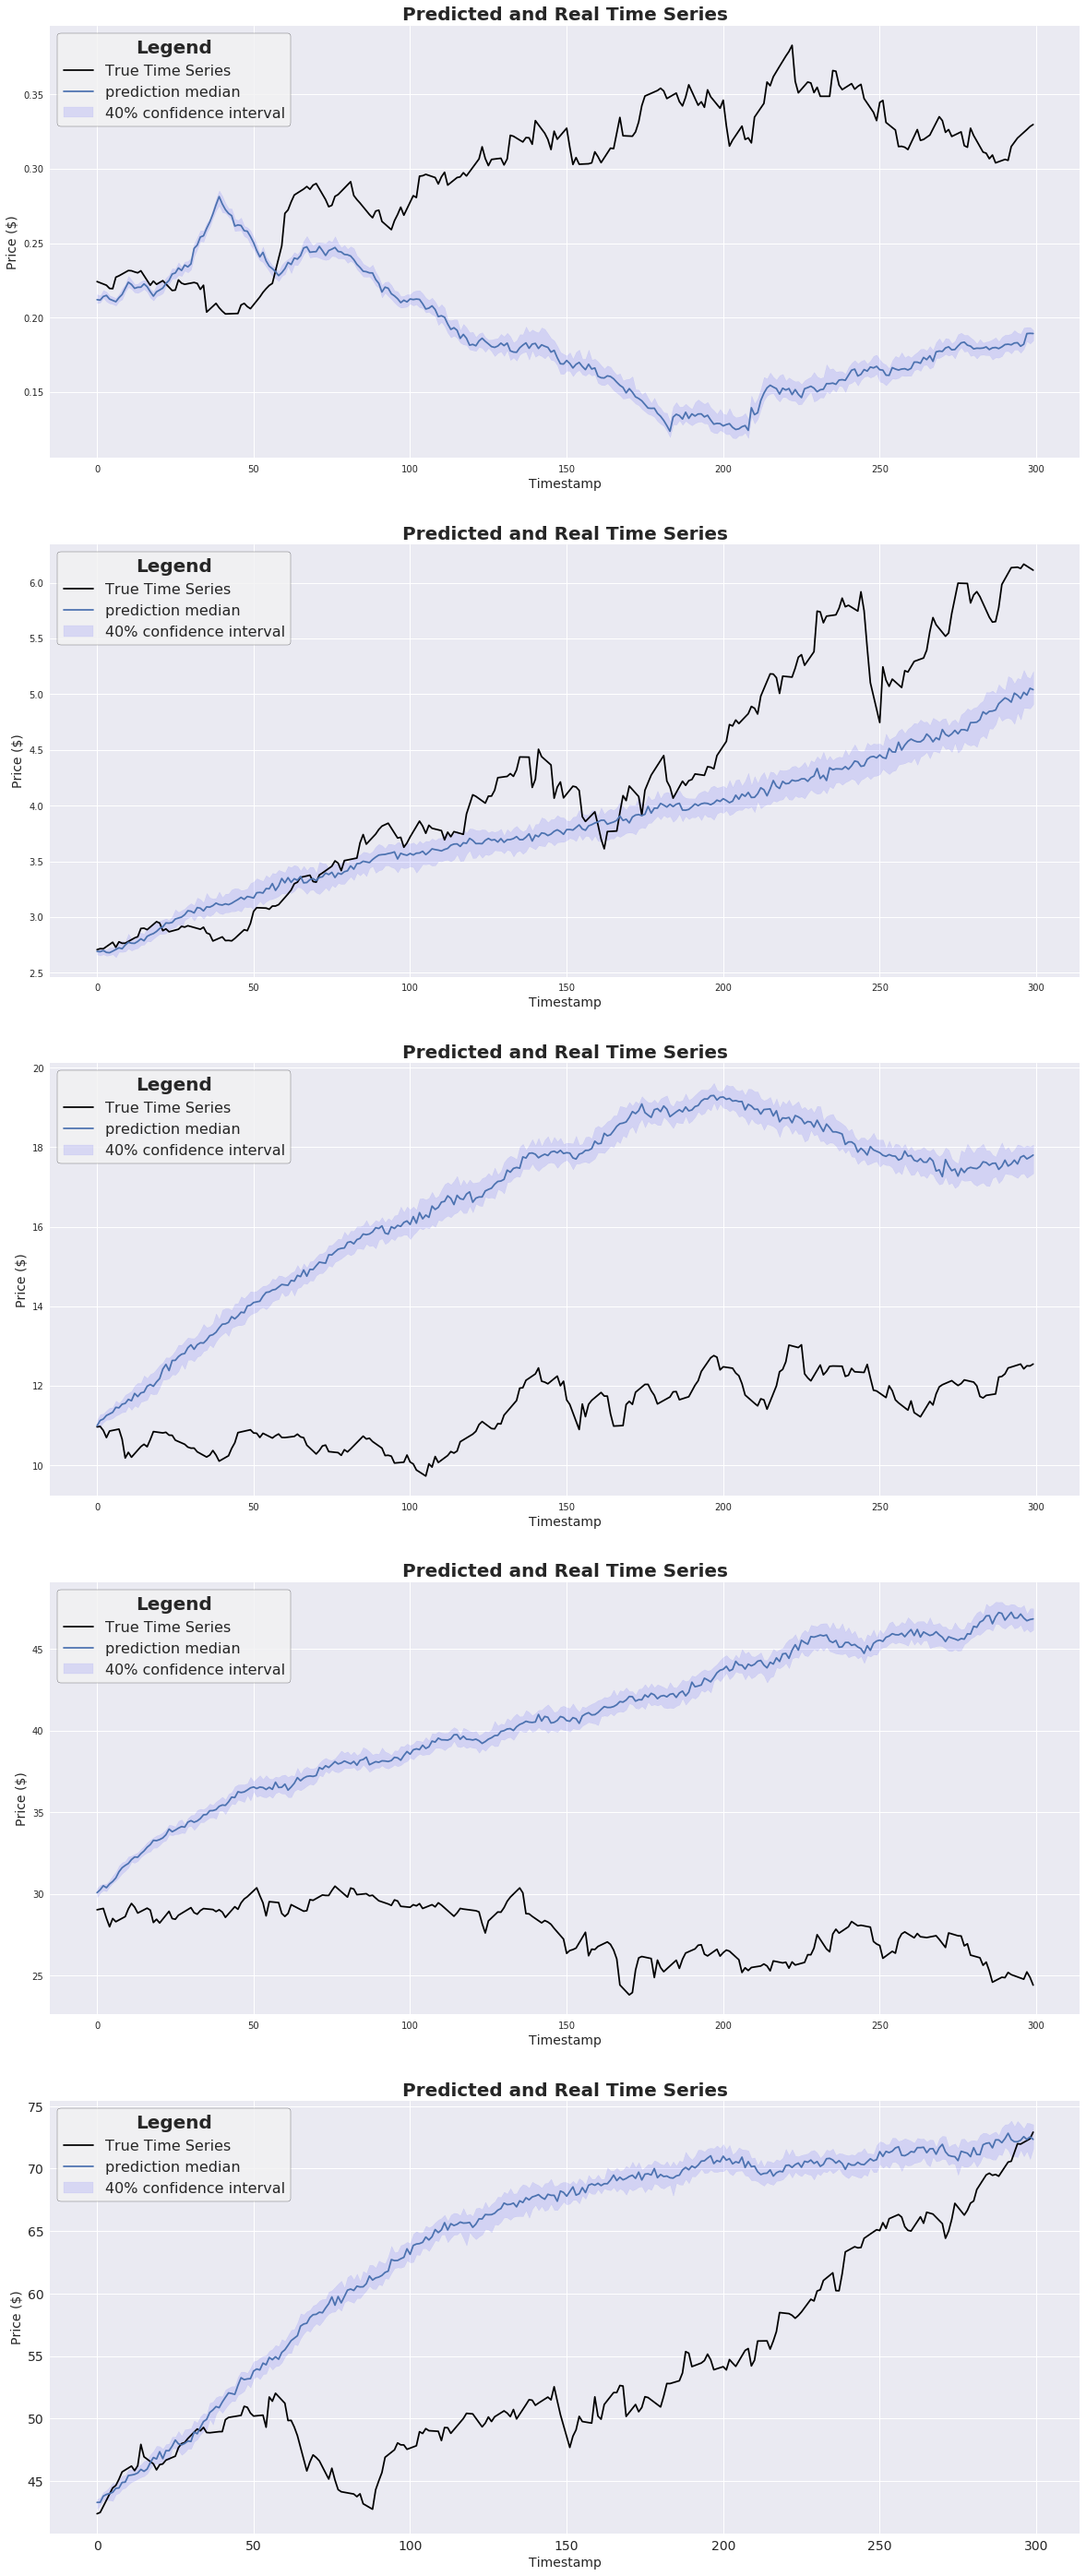

In [54]:
display_results(predictions_list, test_ts_list)

<a id="hyperparameter-tuning-2"></a>
## 2.5 Hyperparameter Tuning - DeepAR
I am going to work on this section after the submission. I believe the model is already performing well, but can be further improved.

<a id="generate-predictions-2"></a>
## 2.6 Generate Predictions - DeepAR
Generating predictions for the first 10 months of 2020.

In [55]:
start_time = datetime.datetime(2020, 1, 1)

# format the request_data
# with "instances" and "configuration"
configuration = {"num_samples": 300, 
                 "output_types": ["quantiles"], 
                 "quantiles": ['0.3', '0.5', '0.7']}

request_data = {"instances": [{"start": str(start_time),
                              "target": []}],
                "configuration": configuration}


# create JSON input
json_request = json.dumps(request_data).encode('utf-8')

print(f'Requesting prediction for {start_time}')

Requesting prediction for 2020-01-01 00:00:00


In [56]:
json_prediction = predictor.predict(json_request)

prediction_2020 = json_to_predictions(json_prediction)

Decoding data...
List creation completed.


In [60]:
end_time = start_time + pd.DateOffset(days=prediction_2020[0].index[-1])
test_ts_2020 = [aapl_data['Adj Close'][start_time:end_time]]

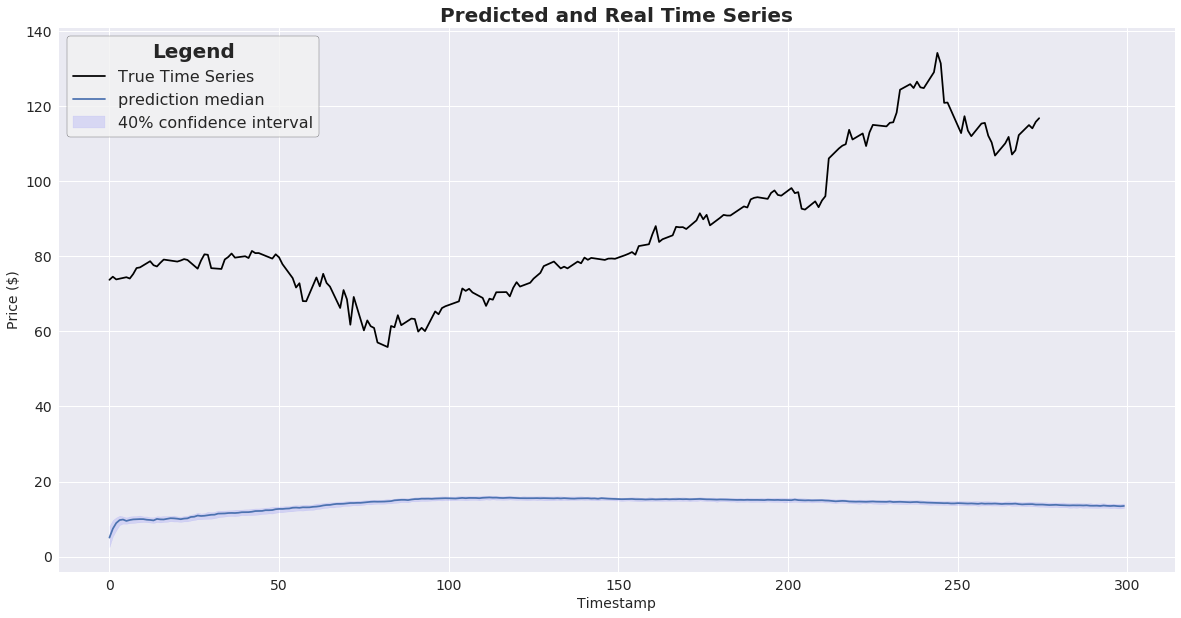

In [61]:
fig, ax = plt.subplots(figsize=(20, 10))
start = datetime.datetime(2004,3,1)

true_ts = test_ts_2020[0]
pred_ts = prediction_2020[0]

true_ts = pd.Series(true_ts.values[-300:])

true_ts.plot(color='black', ax=ax,
             label='True Time Series')

ax.set_title('Predicted and Real Time Series',
             fontdict={'size': 20, 'weight': 'bold'})
ax.set_xlabel('Timestamp', fontdict={"size": 14})
ax.set_ylabel('Price ($)', fontdict={"size": 14})
p30 = pred_ts['0.3']
p70 = pred_ts['0.7']
# fill the 40% confidence interval
ax.fill_between(p30.index, p30, p70, color='blue', alpha=0.1, label='40% confidence interval')
# plot the median prediction line
pred_ts['0.5'].plot(label='prediction median',
                    ax=ax)
#         plt.legend(loc='best')
leg = ax.legend(fontsize=16, frameon=True)
leg.get_frame().set_color('#F2F2F2')
leg.get_frame().set_edgecolor('black')
leg.set_title("Legend", prop={"size": 20, "weight": 'bold'})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

In [63]:
# Delete Endpoint
predictor.delete_endpoint()

######### Metric Scores ##########
Mean Absolute Error:             72.52
Mean Squared Error:              5597.78
Root Mean Squared Error:         74.82
Mean Absolute Percentage Error:  83.05%



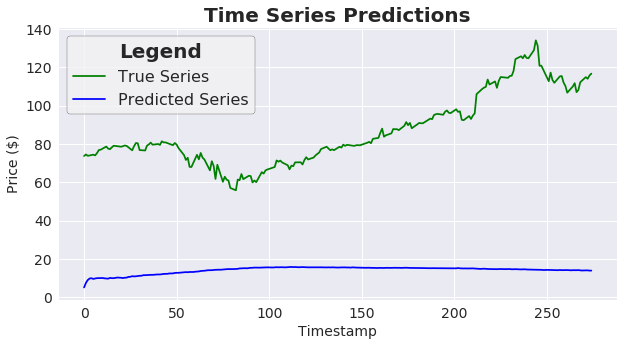

In [67]:
evaluate_model(true_ts, pred_ts['0.5'][:-25]);

The above is the prediction for no context length provided. One can argue that the accuracy of the model is very low, but the precision can be seen to be very high. From the above graph, it is clear that the DeepAR model got the the trend right. More tuning and training is required to get better results out of the algorithm.

######### Metric Scores ##########
Mean Absolute Error:             10.28
Mean Squared Error:              148.92
Root Mean Squared Error:         12.20
Mean Absolute Percentage Error:  19.90%



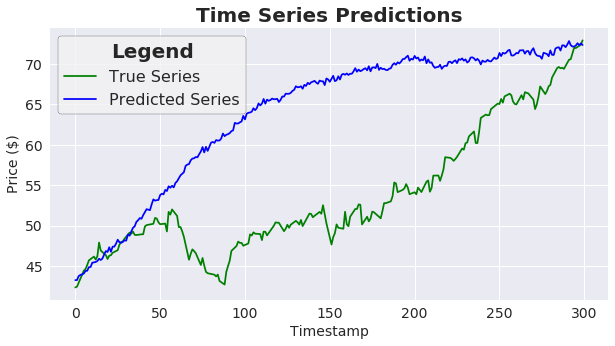

In [69]:
evaluate_model(pd.Series(test_ts_list[-1].values[-300:]), predictions_list[-1]['0.5']);

This is the data to be compared to the ARIMA model results. This is the same date-range for which the ARIMA model is being tested. Even though the DeepAR algorithm has managed to get the start and end points right, there is big difference in the middle. This brings the MAPE value to `19.9%`, which can be considered to be an accuracy of `80.1%`. For the first iteration, this is a positive result. With some hyperparameter tuning, we will be able push accuracy above `90%` mark and MAPE below 10%.

# Future Scopes
1. Multivariate time series analysis with `Open, High, Low, Close` price predictions. End result should produce what the candlestick for next year will look like.
2. Investigating the effects of higher order interpolation to fill in missing data on the performance of the models.